Bike Sharing Analysis - Demand Prediction


Indice:
- Carga de librerias
- EDA
- Desarrollo de hipotesis
- Desarrollo del modelo:
    - Se buscará el mejor resultado entre distintos modelos de Machine Learning, Ridge, Decision Tree, Random Forest, y XGBoost.

Exploratory Data Analysis

El data set esta divido en Train y Test

El data set tiene 13 variables independientes:

- dteday: fecha del registro.
- season: temporada (1: primavera, 2: verano, 3: otoño, 4: invierno).
- yr: año del registro (0: 2011, 1:2012).
- mnth: mes del registro (1 a 12).
- hr: hora del registro (0 a 23).
- holiday: si el día meteorológico es feriado toma el valor 1, sino toma el valor 0
- weekday: día de la semana
- workingday: si el día es laboral toma el valor 1, sino 0. Un día laboral es un día no feriado ni fin de semana.
- weathersit: indica el tipo de clima que hubo el momento del registro, las opciones son:
	- 1: Despejado, algunas nubes o parcialmente nublado.
	- 2: Neblina con nubes, neblina con nubes fragmentadas, neblina con algunas nubes o sólo neblina.
	- 3: Nieve ligera, llovizna con tormenta eléctrica y nubes dispersas o llovizna con nubes dispersas. 
	- 4: Lluvia fuerte con granizos, tormenta eléctrica y neblina, o nieve con niebla.
- temp: temperatura normalizada en grados Celsius. La escala llega hasta un máximo de temperatura de 41ºC.
- atemp: sensación térmica normalizada en grados Celsius. La escala llega hasta un máximo de 50ºC.
- hum: nivel de humedad normalizada. La escala llega hasta un máximo de 100.
- windspeed: velocidad del viento normalizada. La escala llega hasta un máximo de 67 km/h.

In [68]:

# Importing libraries required for the project 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import datetime
from sklearn import linear_model
import datetime as dt
#import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection  import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import plotly.graph_objs as go
import plotly.offline as plotly
from pprint import pprint
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn import svm

In [69]:
# 1) Importo datasets

df_train = pd.read_excel('bike_train.xlsx',index_col="instant")

df_test = pd.read_excel('bike_test.xlsx',index_col="instant")

In [70]:
## Al ser un proceso iterativo buscando mejores resultados, hago un deep copy de las tablas 
# para no tener que volver a cargar el dataset, y ajusto el datetime.



train = df_train.copy()
test = df_test.copy()
train.dteday = pd.to_datetime(train.dteday)
train.dteday = train.dteday.map(dt.datetime.toordinal)
test.dteday = pd.to_datetime(test.dteday)
test.dteday = test.dteday.map(dt.datetime.toordinal)

In [71]:
## Genero columnas faltantes en test para que tengan igual cantidad de columnas

test['casual']=0
test['registered']=0
test['cnt']=0
#test['weathersit_4']=0

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11999 entries, 1 to 11999
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      11999 non-null  int64  
 1   season      11999 non-null  int64  
 2   yr          11999 non-null  int64  
 3   mnth        11999 non-null  int64  
 4   hr          11999 non-null  int64  
 5   holiday     11999 non-null  int64  
 6   weekday     11999 non-null  int64  
 7   workingday  11999 non-null  int64  
 8   weathersit  11999 non-null  int64  
 9   temp        11999 non-null  float64
 10  atemp       11999 non-null  float64
 11  hum         11999 non-null  float64
 12  windspeed   11999 non-null  float64
 13  casual      11999 non-null  int64  
 14  registered  11999 non-null  int64  
 15  cnt         11999 non-null  int64  
dtypes: float64(4), int64(12)
memory usage: 1.6 MB


In [73]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5380 entries, 12000 to 17379
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      5380 non-null   int64  
 1   season      5380 non-null   int64  
 2   yr          5380 non-null   int64  
 3   mnth        5380 non-null   int64  
 4   hr          5380 non-null   int64  
 5   holiday     5380 non-null   int64  
 6   weekday     5380 non-null   int64  
 7   workingday  5380 non-null   int64  
 8   weathersit  5380 non-null   int64  
 9   temp        5380 non-null   float64
 10  atemp       5380 non-null   float64
 11  hum         5380 non-null   float64
 12  windspeed   5380 non-null   float64
 13  casual      5380 non-null   int64  
 14  registered  5380 non-null   int64  
 15  cnt         5380 non-null   int64  
dtypes: float64(4), int64(12)
memory usage: 714.5 KB


In [74]:
#creo variables secundarias para Feature Engineering, en ambos datasets.
train['hr2'] = train['hr']
train['season2'] = train['season']
train['temp2'] = train['temp']
train['hum2'] = train['hum']
train['weekday2'] = train['weekday']
test['hr2'] = test['hr']
test['season2'] = test['season']
test['temp2'] = test['temp']
test['hum2'] = test['hum']
test['weekday2'] = test['weekday']

In [75]:
## Para luego trabajar en Feature Engineering, cambio tipo de datos a las columnas que corresponden a variables categóricas
## en ambos datasets. 


test['season'] = test['season'].astype('category')
test['yr'] = test['yr'].astype('category')
test['mnth'] = test['mnth'].astype('category')
test['hr'] = test['hr'].astype('category')
test['weekday'] = test['weekday'].astype('category')
test['season'] = test['season'].astype('category')
test['weathersit'] = test['weathersit'].astype('category')
test['holiday'] = test['holiday'].astype('category')
test['workingday'] = test['workingday'].astype('category')

train['season'] = train['season'].astype('category')
train['yr'] = train['yr'].astype('category')
train['mnth'] = train['mnth'].astype('category')
train['hr'] = train['hr'].astype('category')
train['weekday'] = train['weekday'].astype('category')
train['season'] = train['season'].astype('category')
train['weathersit'] = train['weathersit'].astype('category')
train['holiday'] = train['holiday'].astype('category')
train['workingday'] = train['workingday'].astype('category')



Visualización de Variables Categóricas

array([[<AxesSubplot:title={'center':'dteday'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'yr'}>,
        <AxesSubplot:title={'center':'mnth'}>],
       [<AxesSubplot:title={'center':'hr'}>,
        <AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'weekday'}>,
        <AxesSubplot:title={'center':'workingday'}>],
       [<AxesSubplot:title={'center':'weathersit'}>,
        <AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'hum'}>],
       [<AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'cnt'}>]], dtype=object)

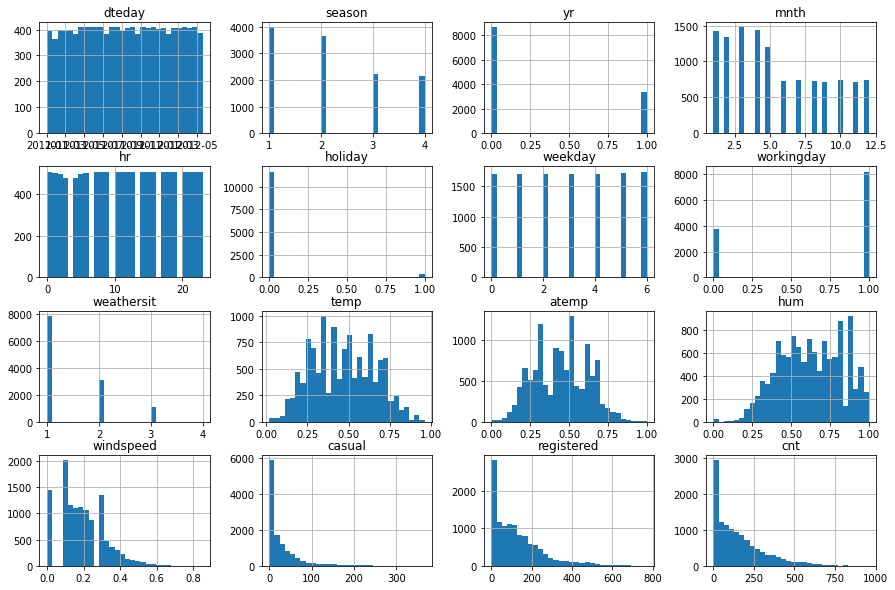

In [76]:
df_train.hist(bins=30, figsize=(15, 10))

Observando el histograma, podemos concluir:
-   La variable Season tiene mas peso en la temporada 1 y 2 (primavera y verano)
-   Hay mas datos en 2011 que en 2012 (2012 solo tiene 5 meses de información) --> validar si eliminando esta columna se mejora el análisis
- 	Puede existir correlación entre month y season.
- 	La variable hour hay que verla en mas detalle.
- 	Hay más utilización de las bicis los días no feriados. Hay que profundizar el análisis para entender como se diferencia la demanda los días hábiles y no hábiles y si es necesario crear una columna extra que contenga el comportamiento de ambas variables (dia de semana y feriado-no feriado).
- 	El clima afecta fuertemente la demanda de bicicletas.
- 	Temp y atemp muestran un comportamiento similar, hay que revisar la correlación y si beneficia al modelo eliminar una de las dos variables. 
- 	Humedad muestra cierto sesgo hacia la derecha, puede ser necesario una transformación logaritmica para normalizarla.
-  Windspeed acumula muchos valores en 0, puede ser un error de carga, y puede ser necesario imputar ese valor para mejorar los resultados. A su vez, muestra sesgo a la izquierda, puede ser necesario aplicar una transformación logarítmica.
- 	CNT muestra cierto sesgo hacia la derecha, puede ser necesario una transformación logaritmica para normalizarla.



Text(0, 0.5, 'Cnt')

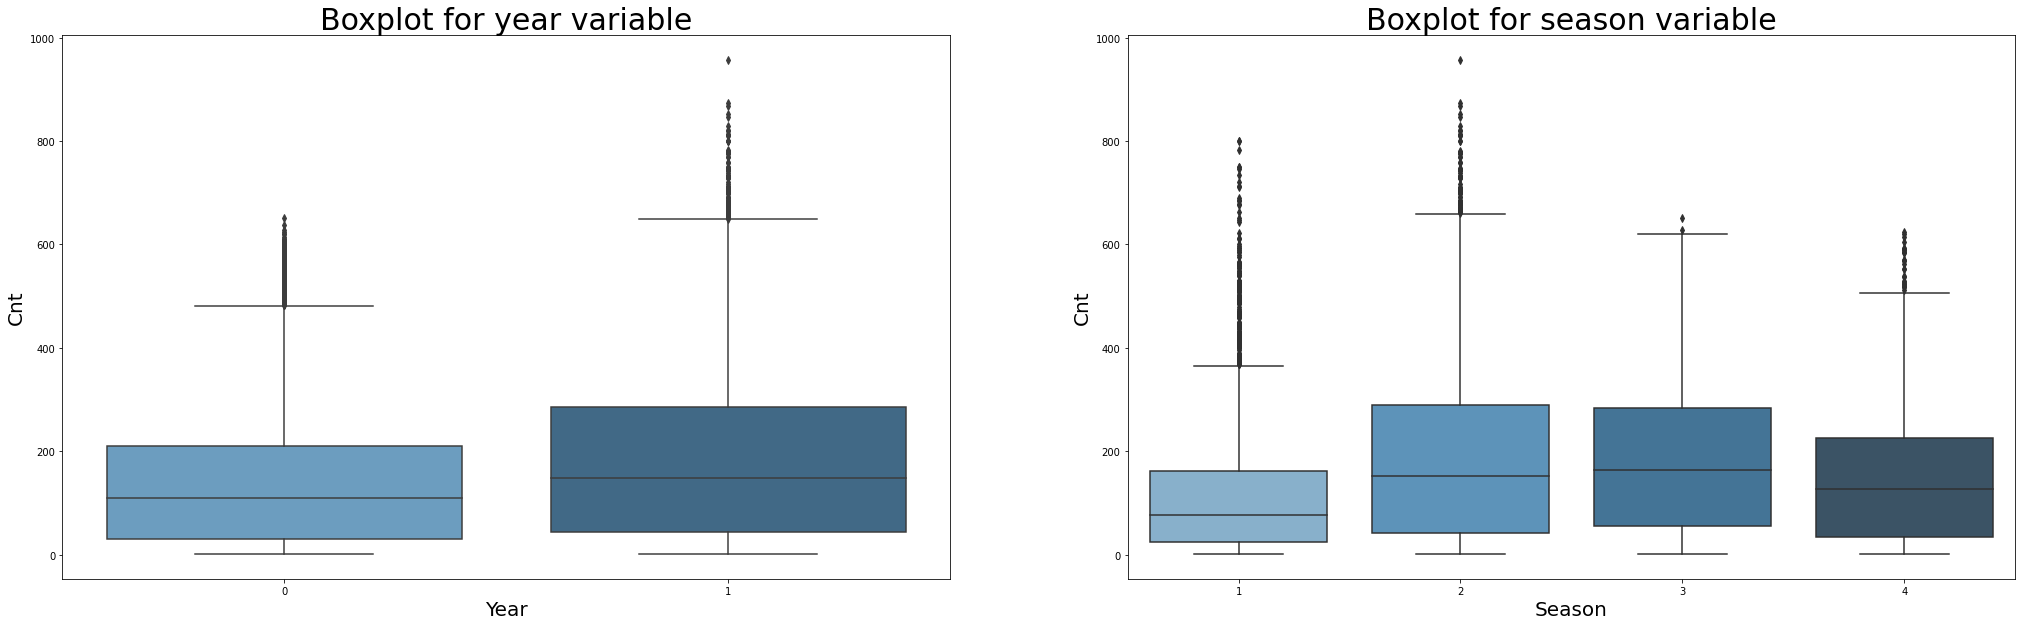

In [77]:
# Demanda por año y temporada
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(35, 10))
sns.boxplot(x="yr", y="cnt", data=train, ax=ax1, palette="Blues_d")
ax1.set_title("Boxplot for year variable",fontsize = 30)
ax1.set_xlabel("Year" , fontsize = 20)
ax1.set_ylabel("Cnt" , fontsize = 20)
sns.boxplot(x="season", y="cnt", data=train, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for season variable",fontsize = 30)
ax2.set_xlabel("Season" , fontsize = 20)
ax2.set_ylabel("Cnt" , fontsize = 20)

Text(0, 0.5, 'Cnt')

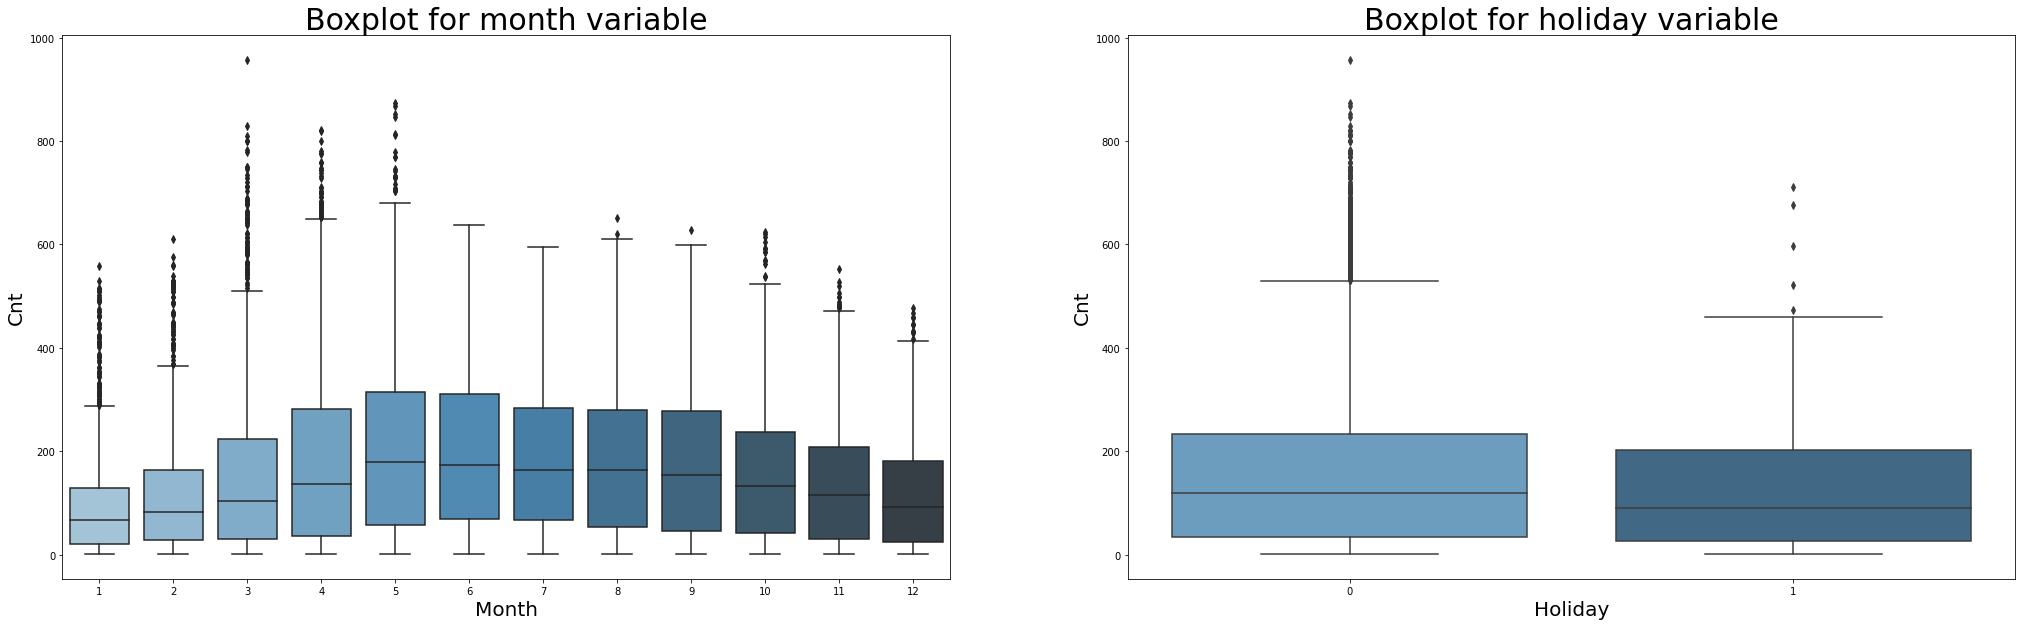

In [78]:
# Demanda por mes, holiday/ no holiday
fig, (ax3, ax4) = plt.subplots(ncols=2, figsize=(35, 10))
sns.boxplot(x="mnth", y="cnt", data=train, ax=ax3, palette="Blues_d")
ax3.set_title("Boxplot for month variable",fontsize =30)
ax3.set_xlabel("Month" , fontsize = 20)
ax3.set_ylabel("Cnt" , fontsize = 20)
sns.boxplot(x="holiday", y="cnt", data=train, ax=ax4, palette="Blues_d")
ax4.set_title("Boxplot for holiday variable",fontsize =30)
ax4.set_xlabel("Holiday" , fontsize = 20)
ax4.set_ylabel("Cnt" , fontsize = 20)

Month: los meses de verano y primavera son días de clima más agradable y corresponde con la mayor demanda en los meses de Mayo a Octubre.

Holiday: las personas alquilan más bicis en los días laborables para viajar al trabajo. 

Text(0, 0.5, 'Cnt')

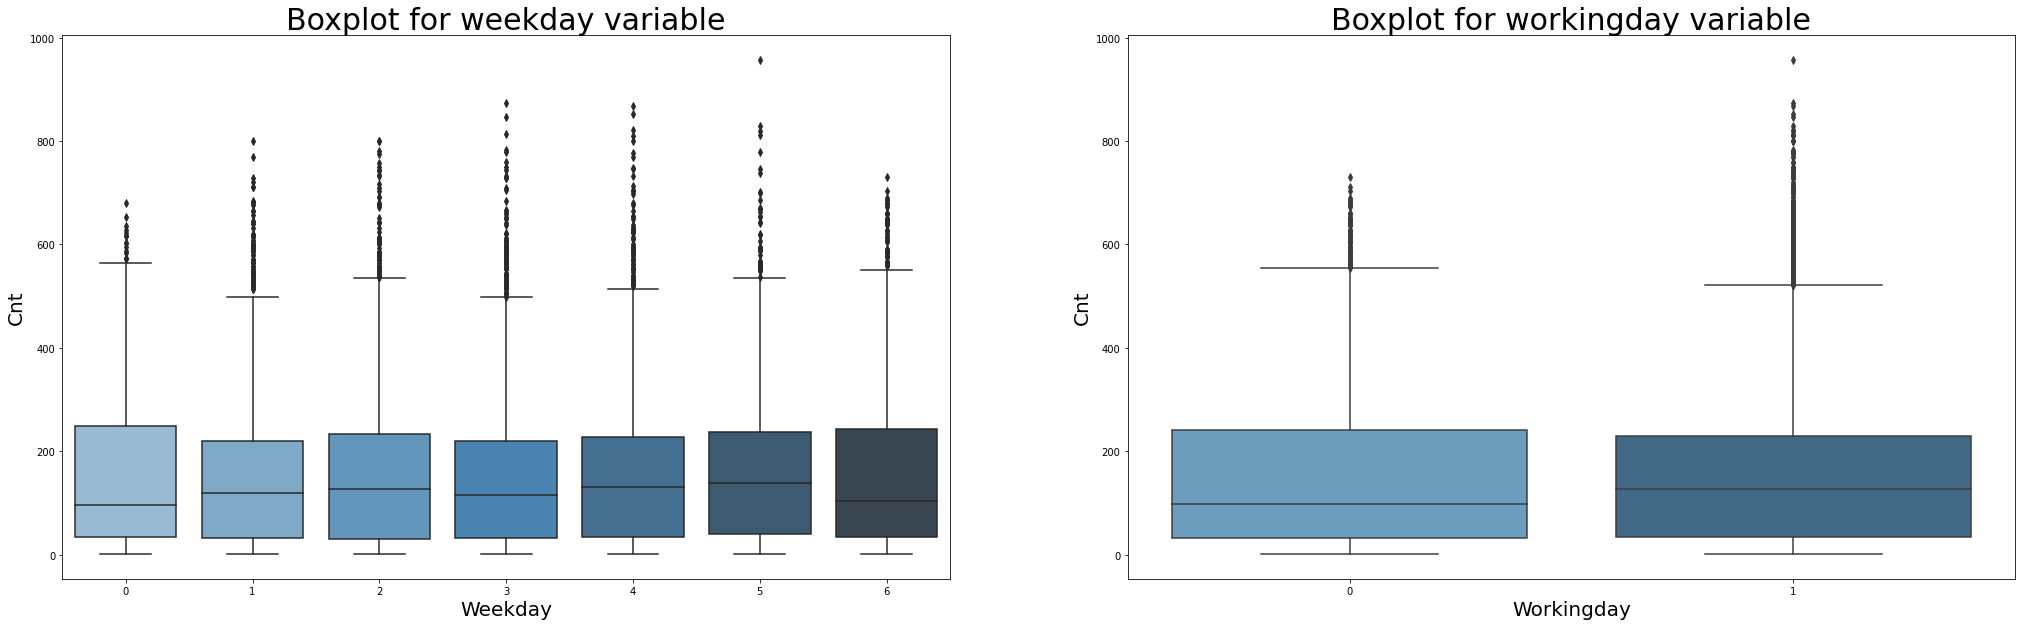

In [79]:
# Demanda por weekday y workingday

fig, (ax5, ax6) = plt.subplots(ncols=2, figsize=(35, 10))
sns.boxplot(x="weekday", y="cnt", data=train, ax=ax5, palette="Blues_d")
ax5.set_title("Boxplot for weekday variable",fontsize=30)
ax5.set_xlabel("Weekday" , fontsize = 20)
ax5.set_ylabel("Cnt" , fontsize = 20)
sns.boxplot(x="workingday", y="cnt", data=train, ax=ax6, palette="Blues_d")
ax6.set_title("Boxplot for workingday variable",fontsize= 30)
ax6.set_xlabel("Workingday" , fontsize = 20)
ax6.set_ylabel("Cnt" , fontsize = 20)

Dado que el objetivo es la demanda total (no aperturado por registrado y casuales), vemos que las diferencias no son muy grandes entre días de semana y working days. Sin embargo, destaca la demanda en días de semana y días laborables, especiamente la media. 


Text(0, 0.5, 'Cnt')

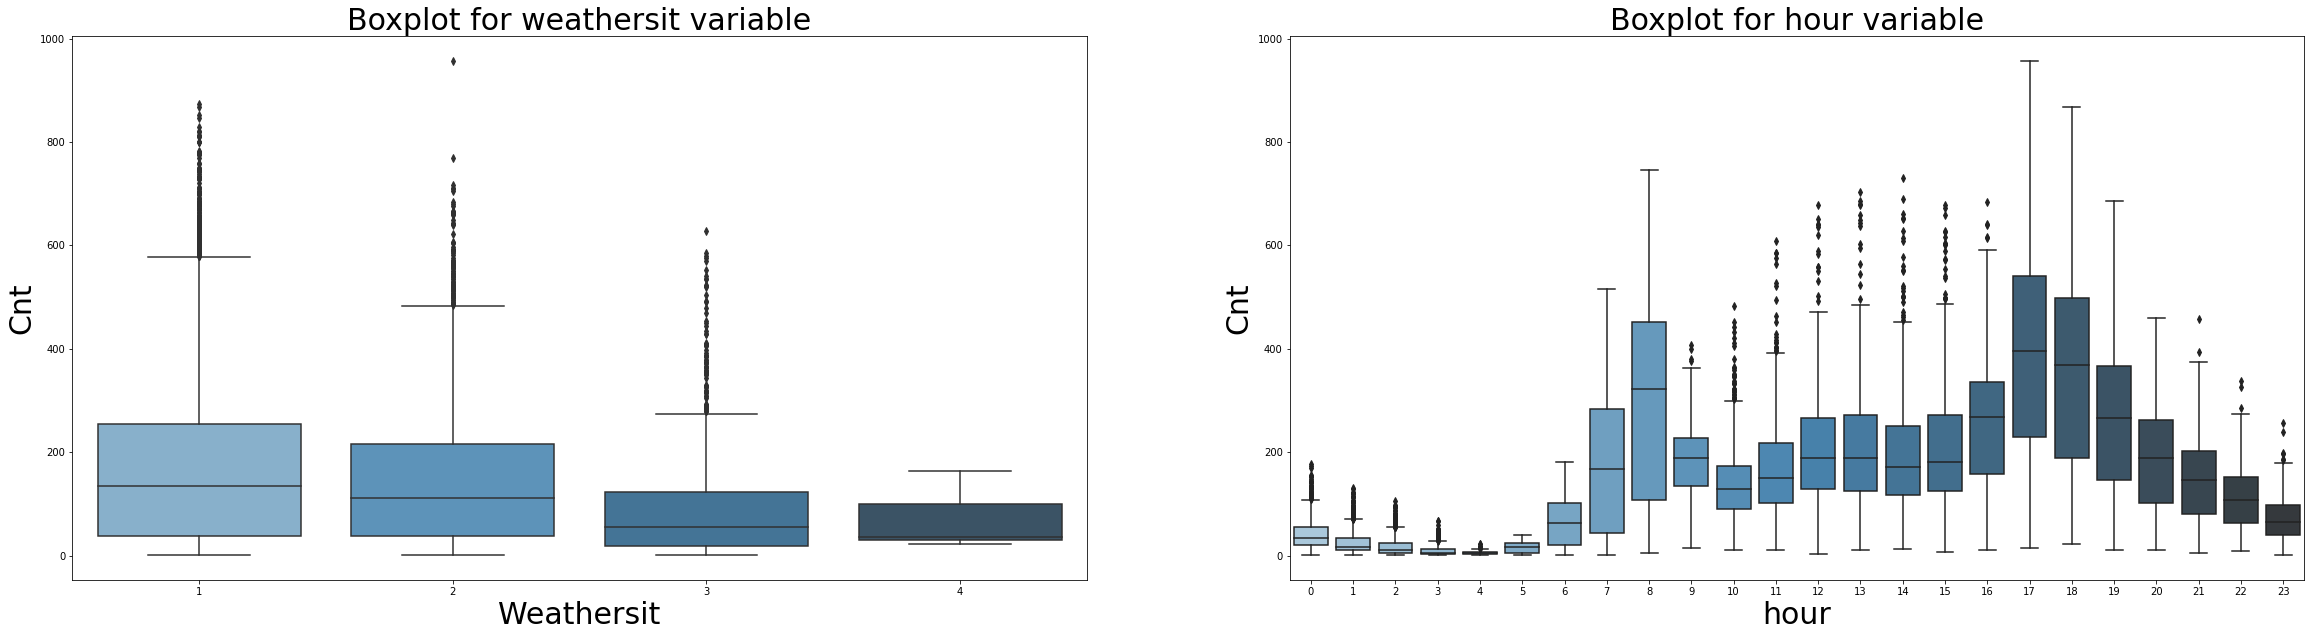

In [80]:
# Total number of passengers by weather situation and hour 
fig, (ax7, ax8) = plt.subplots(ncols=2, figsize=(40, 10))
sns.boxplot(x="weathersit", y="cnt", data=train, ax = ax7, palette="Blues_d")
ax7.set_title("Boxplot for weathersit variable",fontsize=30)
ax7.set_xlabel("Weathersit" , fontsize = 30)
ax7.set_ylabel("Cnt" , fontsize = 30)
sns.boxplot(x="hr", y="cnt", data=train, ax=ax8, palette="Blues_d")
ax8.set_title("Boxplot for hour variable",fontsize= 30)
ax8.set_xlabel("hour" , fontsize = 30)
ax8.set_ylabel("Cnt" , fontsize = 30)

Weather: afecta la demanda, validamos la hipótesis que la demanda es menor los días frios.

Hr: la demanda es mayor en las horas pico, entrada y salida de oficinas/escuelas, etc.por la mañana y la tarde. Merece la pena generar mediante Feature Engineering una categorización de estas horas. 

C:\Users\Julian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0, 'windspeed')

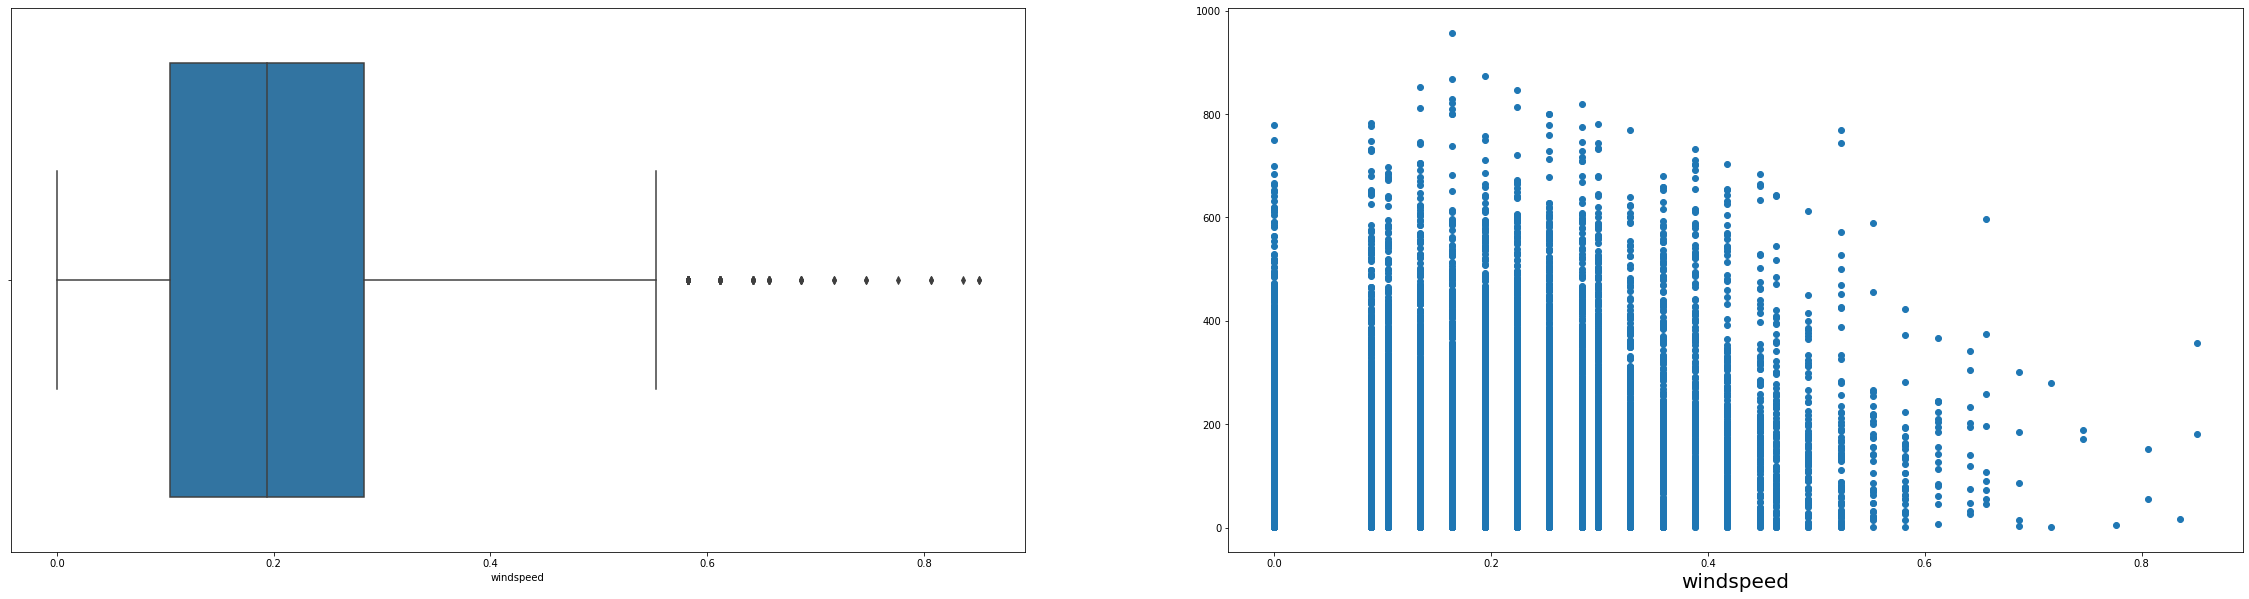

In [81]:
fig, (ax1, ax2)=plt.subplots(ncols=2, figsize=(40,10))
sns.boxplot(train.windspeed, ax= ax1) # No outliers (only a few)
# Plotting the relationship between humidity and cnt 
ax2 = plt.scatter(train.windspeed, train.cnt)
plt.xlabel("windspeed", fontsize = 20)

Como habíamos mencionado, muchos valores de windspeed se acumulan en 0 (cero), posterior a la determinación del mejor modelo analizaremos si imputar ese valor mediante RandomForestClassifier, junto con las variables de temperatura, humedad, y epoca del año tanto para train como para test mejoran el resultado.


## Analizamos la correlación entre variables


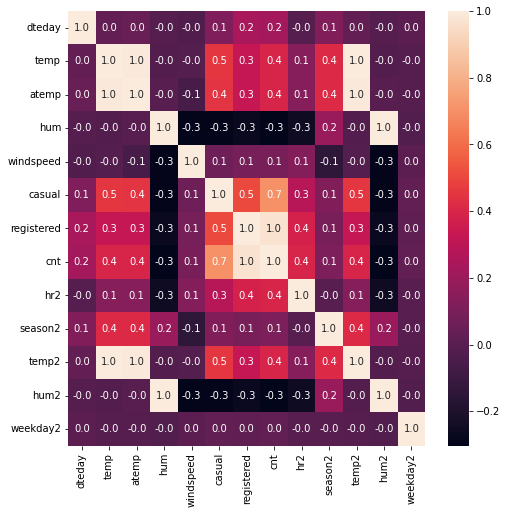

In [82]:
plt.figure(figsize=(8,8))
sns.heatmap(train.corr(),annot=True,fmt='.1f')
plt.show()

Existe correlacion entre temp y atemp, por lo tanto para que no haya multicolinealidad, eliminaremos una de las dos columnas.


### Tratamiento de los sesgos de la data. 

Es necesario para que los modelos de Machine Learning funcionen optimamente, que la data tenga una distribución normal. La transformación se hara tanto en train como test.


C:\Users\Julian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Julian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Julian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619:

<AxesSubplot:xlabel='cnt', ylabel='Density'>

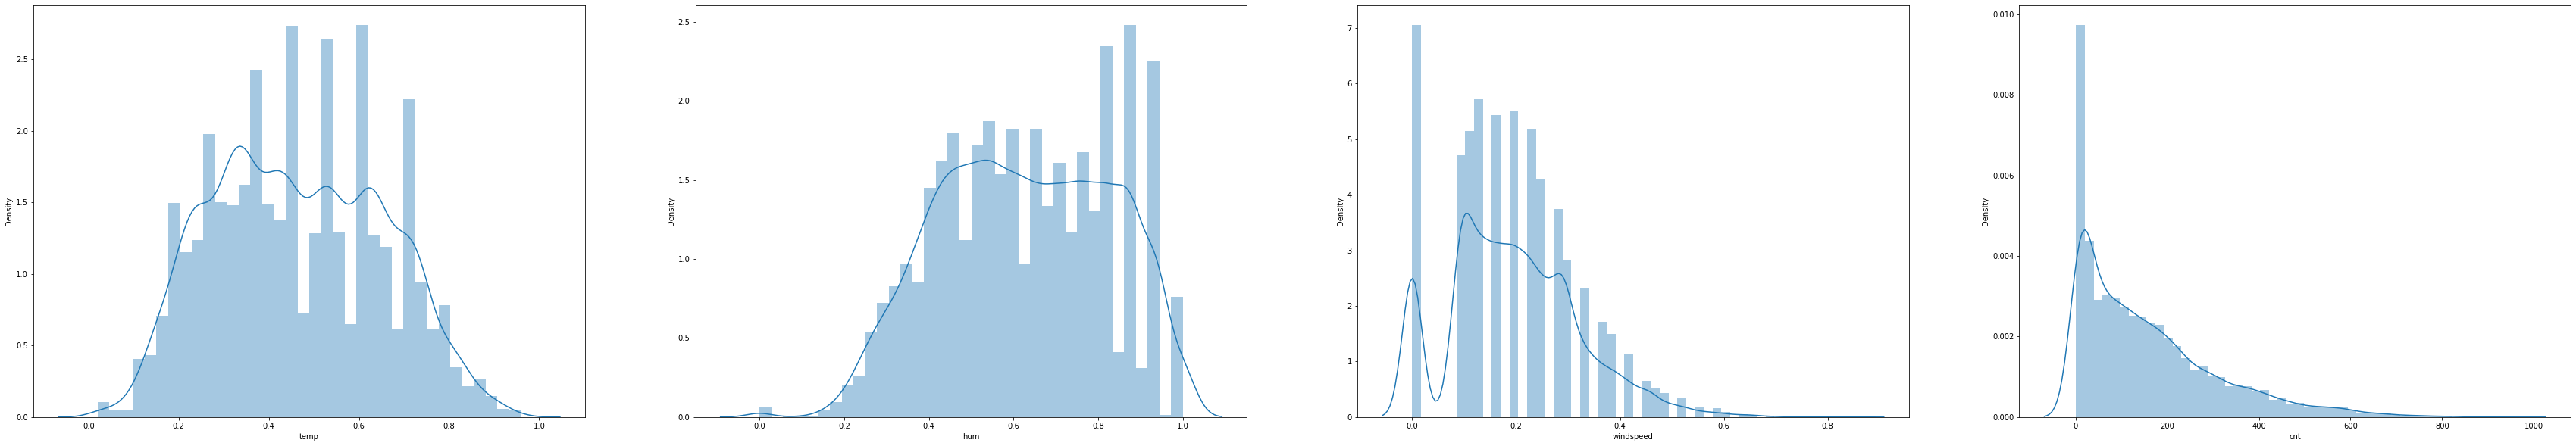

In [83]:
# Plot temp on y bar
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4,figsize=(60, 10))

sns.distplot(train["temp"], ax=ax1)
sns.distplot(train["hum"], ax=ax2)
sns.distplot(train["windspeed"],ax=ax3)
sns.distplot(train["cnt"],ax=ax4)

In [84]:
from scipy.stats import skew
# Analisis de sesgo (skew data).  
logws = round(skew(np.log1p(train.windspeed)),4)
print ("log de windspeed en train es ", logws) 
# Sqrt (raiz cuadrada) 
sqrtws = round(skew(np.sqrt(train.windspeed)),4)
print ("sqrt de windspeed en train es", sqrtws) 

# Log of the count since log0 is invalid so we use log1p.  
logws = round(skew(np.log1p(test.windspeed)),4)
print ("log de windspeed en test es", logws) 
# Sqrt of the count
sqrtws = round(skew(np.sqrt(test.windspeed)),4)
print ("sqrt of the windspeed en test es", sqrtws) 

log de windspeed en train es  0.2522
sqrt de windspeed en train es -0.8949
log de windspeed en test es 0.2458
sqrt of the windspeed en test es -0.9053


In [85]:
# Aplicamos la transformación logaritmica.


train["windspeed"] = np.log1p(train.windspeed)
test["windspeed"] = np.log1p(test.windspeed)

In [86]:
# se hace el mismo análisis para la variable 'cnt', que solo existe en el dataset de train.

from scipy.stats import skew
# Log of the count
logcnt = round(skew(np.log(train.cnt)),4)
print ("log of the count is", logcnt) 
# Sqrt of the count
sqrtcnt = round(skew(np.sqrt(train.cnt)),4)
print ("sqrt of the count is", sqrtcnt) 

log of the count is -0.9455
sqrt of the count is 0.2851


In [87]:
# Aplicamos la transformación logaritmica.

train["cnt"] = np.sqrt(train.cnt)

In [88]:
## no lo mostramos, pero así quedaría la distribución transformada. 

## sns.distplot(train["cnt"], color = "Blue")

### Feature Engineering

 Generaremos columnas nuevas binarias, en las caracteríticas que observamos generaban diferencias en la demanda. Además categorizamos (binning) variables continuas como humedad y temperatura para describir mejor el comportamiento particular en cada caso.

In [89]:
# demanda en horas de oficina
train['hora_oficina'] = np.where((train['hr2'] >= 9) & (train['hr2'] < 17) & (train['weekday2'] == 1), 1 ,0)
train['hora_oficina'] = train['hora_oficina'].astype('category')

# demanda en horas del día 
train['hora_dedia'] = np.where((train['hr2'] >= 6) & (train['hr2'] < 22), 1 ,0)
train['hora_dedia'] = train['hora_dedia'].astype('category')

# demanda en horas pico de la mañana
train['hora_pico_mañana'] = np.where((train['hr2'] >= 6) & (train['hr2'] < 10)  & (train['weekday2'] == 1), 1 ,0)
train['hora_pico_mañana']=train['hora_pico_mañana'].astype('category')

# demanda en horas pico de la tarde
train['hora_pico_tarde'] = np.where((train['hr2'] >= 15) & (train['hr2'] < 19) & (train['weekday2'] == 1), 1 ,0)
train['hora_pico_tarde'] = train['hora_pico_tarde'].astype('category')

# demanda en temporada alta (verano)
train['temporada_alta'] = np.where((train['season2'] == 3), 1 ,0)
train['temporada_alta'] = train['temporada_alta'].astype('category')

# binning de temperatura y humedad en 5 categorias equidistantes
bins = [0, 0.19, 0.49, 0.69, 0.89, 1]
train['temp_etiqueta'] = pd.cut(train['temp2'], bins).astype('category')
train['hum_etiqueta'] = pd.cut(train['hum2'], bins).astype('category')


In [90]:
# demanda en horas de oficina
test['hora_oficina'] = np.where((test['hr2'] >= 9) & (test['hr2'] < 17) & (test['weekday2'] == 1), 1 ,0)
test['hora_oficina'] = test['hora_oficina'].astype('category')

# demanda en horas del día 
test['hora_dedia'] = np.where((test['hr2'] >= 6) & (test['hr2'] < 22), 1 ,0)
test['hora_dedia'] = test['hora_dedia'].astype('category')

# demanda en horas pico de la mañana
test['hora_pico_mañana'] = np.where((test['hr2'] >= 6) & (test['hr2'] < 10)  & (test['weekday2'] == 1), 1 ,0)
test['hora_pico_mañana']=test['hora_pico_mañana'].astype('category')

# demanda en horas pico de la tarde
test['hora_pico_tarde'] = np.where((test['hr2'] >= 15) & (test['hr2'] < 19) & (test['weekday2'] == 1), 1 ,0)
test['hora_pico_tarde'] = test['hora_pico_tarde'].astype('category')

# demanda en temporada alta (verano)
test['temporada_alta'] = np.where((test['season2'] == 3), 1 ,0)
test['temporada_alta'] = test['temporada_alta'].astype('category')

# binning de temperatura y humedad en 5 categorias equidistantes
bins = [0, 0.19, 0.49, 0.69, 0.89, 1]
test['temp_etiqueta'] = pd.cut(test['temp2'], bins).astype('category')
test['hum_etiqueta'] = pd.cut(test['hum2'], bins).astype('category')

In [91]:
test.columns

Index(['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'hr2', 'season2', 'temp2', 'hum2',
       'weekday2', 'hora_oficina', 'hora_dedia', 'hora_pico_mañana',
       'hora_pico_tarde', 'temporada_alta', 'temp_etiqueta', 'hum_etiqueta'],
      dtype='object')

In [92]:
#dropping duplicated rows used for feature engineering
train = train.drop(columns = ['hr2','season2', 'temp2', 'hum2', 'weekday2'],axis=1)
test = test.drop(columns = ['hr2','season2', 'temp2', 'hum2', 'weekday2'],axis=1)

In [93]:
## Genero dummis (OneHotEncoding) para las variables categóricas

train = pd.get_dummies(train,drop_first=True)

test = pd.get_dummies(test,drop_first=True)

## Análisis de Machine Learning 

Dividimos el set de training, en train y test para análizar los distintos modelos, al finalizar utilizaremos el total dataset de training para predecir la demanda del dataset de test.

In [94]:
# dividimos 80% training, 20% test.

data_train = train.iloc[0:9600]
data_test = train.iloc[9601:11999]

In [95]:
data_test.columns

Index(['dteday', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered',
       'cnt', 'season_2', 'season_3', 'season_4', 'yr_1', 'mnth_2', 'mnth_3',
       'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10',
       'mnth_11', 'mnth_12', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6',
       'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14',
       'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22',
       'hr_23', 'holiday_1', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'workingday_1', 'weathersit_2',
       'weathersit_3', 'weathersit_4', 'hora_oficina_1', 'hora_dedia_1',
       'hora_pico_mañana_1', 'hora_pico_tarde_1', 'temporada_alta_1',
       'temp_etiqueta_(0.19, 0.49]', 'temp_etiqueta_(0.49, 0.69]',
       'temp_etiqueta_(0.69, 0.89]', 'temp_etiqueta_(0.89, 1.0]',
       'hum_etiqueta_(0.19, 0.49]', 'hum_etiqueta_(0.49, 0.69]',
       'hum_etiqueta_(0.69, 0.89]', 'hum_etique

In [96]:
# Eliminamos columnas que tenían correlación alta, o no son necesarias para predecir la variable objetivo.

data_train = data_train.drop(columns = ['dteday', 'casual','atemp', 'registered'])
data_test = data_test.drop(columns = ['dteday', 'casual', 'registered','atemp'])

In [97]:
# seperate the independent and target variable on testing data
train_X = data_train.drop(columns=['cnt'],axis=1)
train_y = data_train['cnt']

# seperate the independent and target variable on test data
test_X = data_test.drop(columns=['cnt'],axis=1)
test_y = data_test['cnt']

### Modelo Ridge

In [98]:
ridge = Ridge()
ridge.fit(train_X, train_y)
result_ridge = ridge.predict(test_X)

print("R-squared for Train: %.2f" % ridge.score(train_X, train_y))
print("R-squared for Test: %.2f" % ridge.score(test_X, test_y))


RMSE = np.sqrt(np.mean((test_y** 2 - result_ridge ** 2) ** 2))
MSE = RMSE ** 2

print("MSE ={}".format(MSE))
print("RMSE = {}".format(RMSE))

R-squared for Train: 0.78
R-squared for Test: 0.76
MSE =12062.171203016527
RMSE = 109.82791631919694


In [99]:
dt1 = DecisionTreeRegressor(max_depth=10, min_samples_split=5,max_leaf_nodes=40, random_state=42)
dt1.fit(train_X,train_y)

y_pred = dt1.predict(train_X)
y_pred_test = dt1.predict(test_X)

r2_train = dt1.score(train_X, train_y) # R2 train
r2_test = dt1.score(train_X, train_y) # R2 test

print("R-squared for Train: %.2f" % dt1.score(train_X, train_y))
print("R-squared for Test: %.2f" % dt1.score(test_X, test_y))

RMSE = np.sqrt(np.mean((test_y** 2 - y_pred_test ** 2) ** 2))
MSE = RMSE ** 2

print("MSE ={}".format(MSE))
print("RMSE = {}".format(RMSE))

R-squared for Train: 0.82
R-squared for Test: 0.72
MSE =17028.001501665705
RMSE = 130.4913847794777


In [100]:
gsc = GridSearchCV( estimator=DecisionTreeRegressor(),# Use decision tree regressor 
                    param_grid={"max_depth": (10, 50, 100, 200),
                                "min_samples_split":(5,10,20,40),
                                "max_leaf_nodes":(10,20,100, None)
                               },   # understand the parameters
                    cv=5,
                    scoring="r2",
                    verbose=10, # set this to 10 if it takes too much time 
                    n_jobs=4,
                    )

grid_result = gsc.fit(train_X, train_y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [101]:
gsc.best_params_

{'max_depth': 100, 'max_leaf_nodes': None, 'min_samples_split': 20}

In [102]:
dt3 = DecisionTreeRegressor(max_depth=100, min_samples_split=20,max_leaf_nodes=None, random_state=42)

dt3.fit(train_X, train_y)

result_dt = dt3.predict(test_X)

r2_train = dt3.score(train_X, train_y) # R2 train
r2_test = dt3.score(train_X, train_y) # R2 test


print("R-squared for Train: %.2f" % dt3.score(train_X, train_y))
print("R-squared for Test: %.2f" % dt3.score(test_X, test_y))

RMSE = np.sqrt(np.mean((test_y** 2 - result_dt ** 2) ** 2))
MSE = RMSE ** 2

print("MSE ={}".format(MSE))
print("RMSE = {}".format(RMSE))

R-squared for Train: 0.96
R-squared for Test: 0.76
MSE =14317.891443112165
RMSE = 119.65739192842273


random forest

In [103]:
rf = RandomForestRegressor(n_estimators = 50, random_state = 42)
rf.fit(train_X, train_y)
result = rf.predict(test_X)



print("R-squared for Train: %.2f" % rf.score(train_X, train_y))
print("R-squared for Test: %.2f" % rf.score(test_X, test_y))


RMSE = np.sqrt(np.mean((test_y ** 2 - result ** 2) ** 2))
MSE = RMSE ** 2

print("MSE ={}".format(MSE))
print("RMSE = {}".format(RMSE))

R-squared for Train: 0.99
R-squared for Test: 0.80
MSE =12595.65762460767
RMSE = 112.23037745908043


In [ ]:

gsc = GridSearchCV(estimator=RandomForestRegressor(),
                    param_grid={ 'max_depth': [10, 40, ],
                                 'min_samples_leaf': [1, 2],
                                 'min_samples_split': [2, 5],
                                 'n_estimators': [200, 400]
                               },
                    cv=5,
                    scoring="r2",
                    verbose=10,
                    n_jobs=4,
                    )

grid_result = gsc.fit(train_X, train_y)

In [ ]:
gsc.best_params_

In [106]:
rf = RandomForestRegressor(max_depth = 40,
                           min_samples_leaf = 1,
                           min_samples_split = 2,
                           n_estimators= 400,
                           random_state = 42)
rf.fit(train_X, train_y)
result_rf = rf.predict(test_X)



print("R-squared for Train: %.2f" % rf.score(train_X, train_y))
print("R-squared for Test: %.2f" % rf.score(test_X, test_y))


RMSE = np.sqrt(np.mean((test_y** 2 - result_rf ** 2) ** 2))
MSE = RMSE ** 2

print("MSE ={}".format(MSE))
print("RMSE = {}".format(RMSE))

R-squared for Train: 0.99
R-squared for Test: 0.80
MSE =12461.219095571452
RMSE = 111.62983067071029


### Modelo XGBoost

In [107]:
# Preprocesamiento extra para XGboost

train_XGB = pd.get_dummies(train)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
train_XGB.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in train_XGB.columns.values]
train_XGB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11999 entries, 1 to 11999
Data columns (total 70 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   dteday                      11999 non-null  int64  
 1   temp                        11999 non-null  float64
 2   atemp                       11999 non-null  float64
 3   hum                         11999 non-null  float64
 4   windspeed                   11999 non-null  float64
 5   casual                      11999 non-null  int64  
 6   registered                  11999 non-null  int64  
 7   cnt                         11999 non-null  float64
 8   season_2                    11999 non-null  uint8  
 9   season_3                    11999 non-null  uint8  
 10  season_4                    11999 non-null  uint8  
 11  yr_1                        11999 non-null  uint8  
 12  mnth_2                      11999 non-null  uint8  
 13  mnth_3                      119

In [108]:
train_XGB = train_XGB.select_dtypes(exclude='category')

In [109]:
train_XGB_train = train_XGB.iloc[0:9600]
train_XGB_test = train_XGB.iloc[9601:11999]


In [110]:
train_XGB_train = train_XGB_train.drop(columns = ['dteday', 'casual','atemp', 'registered'])
#hour_d_validation = hour_d_validation.drop(columns = ['dteday', 'casual','atemp', 'registered'])
train_XGB_test = train_XGB_test.drop(columns = ['dteday', 'casual','atemp', 'registered'])

In [111]:
# seperate the independent and target variable on testing data
train_XGB_train_x = train_XGB_train.drop(columns=['cnt'],axis=1)
train_XGB_train_y = train_XGB_train['cnt']

# seperate the independent and target variable on test data
train_XGB_test_x = train_XGB_test.drop(columns=['cnt'],axis=1)
train_XGB_test_y = train_XGB_test['cnt']

In [112]:
xgb = XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators=15,
                 objective="reg:squarederror", subsample=0.8,
                 colsample_bytree=1, seed=1234, gamma = 1)

xgb.fit(train_XGB_train_x, train_XGB_train_y)

result = xgb.predict(train_XGB_test_x)

In [113]:
print("R-squared for Train: %.2f" % xgb.score(train_XGB_train_x, train_XGB_train_y))
print("R-squared for Test: %.2f" % xgb.score(train_XGB_test_x, train_XGB_test_y))


RMSE = np.sqrt(np.mean((train_XGB_test_y ** 2 - result ** 2) ** 2))
MSE = RMSE ** 2

print("MSE ={}".format(MSE))
print("RMSE = {}".format(RMSE))

R-squared for Train: -2.08
R-squared for Test: -2.32
MSE =85581.63582047378
RMSE = 292.5433913464356


In [ ]:
gsc = GridSearchCV(estimator=XGBRegressor(),
                    param_grid={"max_depth": (6,7),
                                "learning_rate": (0.06, 0.08),
                                "n_estimators": (400, 600),
                                "subsample":(0.7,0.8),
                                "colsample_bytree":(0.4,0.5),
                                "gamma" : (1.4,1.5)
                               },
                    cv=5,
                    scoring="r2",
                    verbose=10, #possibly 10 when takes too long
                    n_jobs=4,
)

grid_result = gsc.fit(train_XGB_train_x, train_XGB_train_y)

In [ ]:
gsc.best_params_

In [114]:
xgb = XGBRegressor(max_depth=6, learning_rate=0.08, n_estimators=1000,
                 objective="reg:squarederror", subsample=0.7,
                 colsample_bytree=0.4, seed=1234, gamma = 1.5)

xgb.fit(train_XGB_train_x, train_XGB_train_y)

result = xgb.predict(train_XGB_test_x)

In [150]:
train['cnt']

instant
1         4.000000
2         6.324555
3         5.656854
4         3.605551
5         1.000000
           ...    
11995    15.459625
11996    13.038405
11997    11.401754
11998     9.899495
11999     8.124038
Name: cnt, Length: 11999, dtype: float64

In [154]:
result.max()

8.199339

In [155]:
train['cnt'].max()

30.93541659651604

In [115]:
print("R-squared for Train: %.2f" % xgb.score(train_XGB_train_x, train_XGB_train_y))
print("R-squared for Test: %.2f" % xgb.score(train_XGB_test_x, train_XGB_test_y))


RMSE = np.sqrt(np.mean((train_XGB_test_y ** 2 - result ** 2) ** 2))
MSE = RMSE ** 2

print("MSE ={}".format(MSE))
print("RMSE = {}".format(RMSE))

R-squared for Train: 0.98
R-squared for Test: 0.87
MSE =8210.207837801732
RMSE = 90.61019720650503


# El mejor resultado de RMSE se obtiene con el Modelo XGBoost

In [ ]:
test['weathersit_4']=0

In [ ]:
test['weathersit_4'] = test['weathersit_4'].astype('category')

### Modelo XGBoost con todo el dataset train, y prediccion en test


In [116]:
train_XGB = pd.get_dummies(train)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
train_XGB.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in train_XGB.columns.values]
train_XGB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11999 entries, 1 to 11999
Data columns (total 70 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   dteday                      11999 non-null  int64  
 1   temp                        11999 non-null  float64
 2   atemp                       11999 non-null  float64
 3   hum                         11999 non-null  float64
 4   windspeed                   11999 non-null  float64
 5   casual                      11999 non-null  int64  
 6   registered                  11999 non-null  int64  
 7   cnt                         11999 non-null  float64
 8   season_2                    11999 non-null  uint8  
 9   season_3                    11999 non-null  uint8  
 10  season_4                    11999 non-null  uint8  
 11  yr_1                        11999 non-null  uint8  
 12  mnth_2                      11999 non-null  uint8  
 13  mnth_3                      119

In [135]:
train_XGB = train_XGB.drop(columns=['mnth_2','mnth_3','mnth_4','mnth_5','weathersit_4','yr_1'],axis=1)

In [136]:
train_XGB = train_XGB.select_dtypes(exclude='category')

In [137]:

train_XGB_x = train_XGB.drop(columns=['cnt'],axis=1)
train_XGB_y = train_XGB['cnt']


train_XGB_x.shape, train_XGB_y.shape,

((11999, 63), (11999,))

In [127]:
# Preprocesamiento extra para XGboost

test_XGB = pd.get_dummies(test)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
test_XGB.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in test_XGB.columns.values]
test_XGB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5380 entries, 12000 to 17379
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   dteday                      5380 non-null   int64  
 1   temp                        5380 non-null   float64
 2   atemp                       5380 non-null   float64
 3   hum                         5380 non-null   float64
 4   windspeed                   5380 non-null   float64
 5   casual                      5380 non-null   int64  
 6   registered                  5380 non-null   int64  
 7   cnt                         5380 non-null   int64  
 8   season_2                    5380 non-null   uint8  
 9   season_3                    5380 non-null   uint8  
 10  season_4                    5380 non-null   uint8  
 11  mnth_6                      5380 non-null   uint8  
 12  mnth_7                      5380 non-null   uint8  
 13  mnth_8                      

In [138]:
train_XGB_x.columns.difference(test_XGB_x.columns)

Index(['atemp', 'casual', 'dteday', 'registered'], dtype='object')

In [128]:
test_XGB_x = test_XGB.drop(columns=['cnt'],axis=1)
test_XGB_y = test_XGB['cnt']


test_XGB_x.shape, test_XGB_y.shape

((5380, 63), (5380,))

In [139]:
train_XGB_x = train_XGB.drop(columns = ['dteday', 'casual','atemp', 'registered'])
#hour_d_validation = hour_d_validation.drop(columns = ['dteday', 'casual','atemp', 'registered'])
test_XGB_x = test_XGB.drop(columns = ['dteday', 'casual','atemp', 'registered'])

In [130]:
train_XGB.shape, train_XGB.shape

((11999, 70), (11999, 70))

In [ ]:
gsc = GridSearchCV(estimator=XGBRegressor(),
                    param_grid={"max_depth": (6,7),
                                "learning_rate": (0.06, 0.08),
                                "n_estimators": (400, 600),
                                "subsample":(0.7,0.8),
                                "colsample_bytree":(0.4,0.5),
                                "gamma" : (1.4,1.5)
                               },
                    cv=5,
                    scoring="r2",
                    verbose=10, #possibly 10 when takes too long
                    n_jobs=4,
)

grid_result = gsc.fit(train_XGB_x, train_XGB_y)

In [ ]:
gsc.best_params_

In [140]:
xgb = XGBRegressor(max_depth=6, learning_rate=0.06, n_estimators=600,
                 objective="reg:squarederror", subsample=0.8,
                 colsample_bytree=0.5, seed=1234, gamma = 1.5)

xgb.fit(train_XGB_x, train_XGB_y)



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=1.5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.06, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=600, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=1234,
             reg_alpha=0, reg_lambda=1, ...)

In [145]:
prediction = xgb.predict(test_XGB_x)

In [157]:
prediction.max()

8.199339

In [167]:
csv = pd.DataFrame(prediction, columns=['pred'])

In [147]:
csv.head(5)

,pred
0,1.591931
1,1.459325
2,2.409625
3,3.221062
4,3.746557


In [168]:
csv.to_csv('JulianLangberg.csv',index=False)